# Overview

This module focuses on converting NFA to RE. This is achieved by eliminating states one by one, and building an abstract syntax tree for the RE generated at each stage. Finally, the abstract syntax tree is rendered into an RE string.

# Top-level functions in this module

```
This module contains the following functions that may be used in other modules to exercise concepts, compose functions, etc.

N  : NFA
D  : DFA
G  : GNFA

def mk_gnfa(N):
def mk_gnfa_from_D(D):
def dfa2nfa(D):
def del_gnfa_states(Gin):
```

In [1]:
from jove.Module5_RE  import re2nfa

from jove.Module4_NFA import nfa2dfa

from jove.Module4_NFA import min_dfa_brz

from jove.Module3_DFA import min_dfa

from jove.SystemImports import *    

from jove.DotBashers  import *

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)

The DFA are NOT language equivalent!
Path leading to counterexample is: 
[(('IF', 'IF'), ('IF', 'IF')), (('A', 'A'), ('A', 'A')), (('B', 'B'), ('B', 'B'))]

Q: {'S2', 'S0', 'S1', 'F', 'I'}
Sigma: {'0', '1'}
Q0: {'I'}
F: {'F'}
Delta:
S2	S0	S1	F	I
---------------------------------------------
{'F'}	set()	{'S2'}	set()	{'I'}		0

set()	set()	set()	set()	{'S0'}		

{'F'}	{'S1'}	{'S2'}	set()	{'I', 'S0'}		1

States reached =  {'A1'}
States reached =  {'S1', 'I', 'S0'}
States reached =  {'S2', 'I', 'S0'}
States reached =  {'I', 'S0', 'F'}
States reached =  {'I', 'S0'}
States reached =  {'I', 'S0'}
States reached =  {'S1', 'I', 'S0'}
States reached =  {'S2', 'S0', 'S1', 'I'}
States reached =  {'S2', 'S0', 'F', 'I'}
NFA rejects ''
States reached =  {'I', 'S0'}
NFA rejects '0'
States reached =  {'S1', 'I', 'S0'}
States reached =  {'S2', 'I', 'S0'}
States reached =  {'I', 'S0', 'F'}
NFA accepts '100' by reaching {'I', 'S0', 

## Algorithm

The algorithm is spelled out along these major steps:

* If given a DFA, convert it to an NFA, else proceed with given NFA

* Pick a state to eliminate 

    - doing this interactively, state by state, would make for a good interactive animation

* Find replacement paths for the state

* Do this till all states except GNFA's initial and final are gone
 

In [2]:
def opr(E):
    return E[0]

def arg1(E):
    return E[1][0]

def arg2(E):
    return E[1][1]

def arg(E):
    return E[1]

In [3]:
def RE2Str(RE):
    """Given an RE as a tree, return the string equivalent of the RE.
    """
    if type(RE) == str:
        if (RE == ""):
            return '""'  # was return '@', but now no more '@'
        else:
            return RE
    elif type(RE) == tuple:
        if opr(RE) == "*":
            return( "("+ RE2Str(arg(RE)) + ")*")
        elif opr(RE) == "+":
            return ( "("+ RE2Str(arg1(RE)) + " + " +
                          RE2Str(arg2(RE)) +")" )
        elif opr(RE) == ".":
            return ( "("+ RE2Str(arg1(RE)) + " "  +
                          RE2Str(arg2(RE)) +
                     ")" )
        else:
            print("Illegal RE detected in RETree2Str")

In [4]:
RE2Str("")

'""'

In [5]:
def mk_gnfa(Nin):
    """Input : Nin, an NFA.
       Output: G, a GNFA, with at-most one transition from any
               state p to a state q.??true any more?? Note that we have created
               an NFA (G+NFA), and so one state can have a transition
               to A SET OF STATES !!
       Method: Add a new set of states {Real_I} and another, {Real_F}.
               Move from state Real_I to the NFA's initial set of states
               upon epsilon, and from each state in NFA's F to Real_F.
               Return this GNFA.
               We will keep GNFA's alphabet implicit (whatever edge
               labels exist will be deemed to be in the alphabet.)
    """
    assert(
        is_consistent_nfa(Nin)
    ), "NFA given to mk_gnfa is not consistent."
    N       = copy.deepcopy(Nin)
    GNFA_Q0 = {"Real_I"} # Name Real_I reserved for GNFA's starting state
    GNFA_F  = {"Real_F"} # Name Real_F reserved for GNFA's final state
    GNFA_Q  = N["Q"] | GNFA_Q0 | GNFA_F
    # Start with NFA's moves in Delta accumulator
    GNFA_Delta = N["Delta"]
    # Add a jump from Real_I to the original initial state
    GNFA_Delta.update({ ("Real_I","") : N["Q0"] })   
    # Add all "original final" to "Real_F" moves
    GNFA_Delta.update({ (f, "") : GNFA_F for f in N["F"] })    
    # Return the GNFA
    return { "Q"     : GNFA_Q,
             "Sigma" : N["Sigma"],
             "Delta" : GNFA_Delta,
             "Q0"    : GNFA_Q0,
             "F"     : GNFA_F }

def mk_gnfa_from_D(D):
    """Given a DFA D, turn that into a GNFA by first making the D
       into an equivalent N, and then passing onto mk_gnfa.
    """
    assert(
    is_partially_consistent_dfa(D)
    ), "DFA given to mk_gnfa_from_D is not part. consist."
    return mk_gnfa(dfa2nfa(D))

def dfa2nfa(D):
    """Given a DFA D, make a language-equivalent NFA.
    """
    assert(
    is_partially_consistent_dfa(D)
    ), "DFA given to dfa2nfa is not part. consist."
    return { "Q"     : D["Q"],
             "Sigma" : D["Sigma"],
             "Delta" : dict((a,{b}) for (a,b) in D["Delta"].items()),
             "Q0"    : { D["q0"] },
             "F"     : D["F"] }   

def del_gnfa_states(Gin):
    """Given a GNFA G with no unreachable states, 
       delete all states but f
       or Real_I and Real_F.
       
       Return a triple (Gfinal, dotObj_List, final_re_str), where
         Gfinal       : the final GNFA
         dotObj_List  : a list of Dot objects recording the process of
                        deleting states and forming intermediate REs
         final_re_str : the final RE as a string (ready to be fed to  
                        re2nfa for converting back to an NFA)
    """
    G = copy.deepcopy(Gin) # To preserve the given GNFA
    StatesLeft  = G["Q"]
    dotObj_List = [ dotObj_gnfa(G) ] # List of intermediate GNFAs  
    while len(StatesLeft) > 2: # Exists one more than Real_I,Real_F
        (qdel, StatesLeft) = choose_state_to_del(G, StatesLeft)
        print("**** Eliminating state " + qdel + " ****")
         
        New_Edges = dict() #-- Brand new edges; ALL new paths supported 
                           #-- by qdel 
        for p in StatesLeft:
            for q in StatesLeft:
                new_p_q_label = del_one_gnfa_state(G, p, qdel, q)
                if new_p_q_label != "NOPATH": # There is a p-qdel->q path
                    old_p_q_labels = Edges_Exist_Via(G, p, q) # Exist p-qdel->q edges?
                    if old_p_q_labels != "NOEDGE":            # There are.
                        combined_label = form_alt_RE( [new_p_q_label] + old_p_q_labels )                                    
                        New_Edges.update( { (p, combined_label) : {q} } )
                    else:
                        # Only new_p_q_label needs to be added
                        New_Edges.update( { (p, new_p_q_label)  : {q} } )
                #else no new path involving qdel exists for THIS p,q pair
            #-end for
        #-end for
        G["Q"] = StatesLeft   # Fix G by adjusting its Q 
        
        # Extinguish qdel from Delta by (1) and (2) below
        Surviving_Edges = []  # These edges don't get nuked
        for ((q,symb), States) in G["Delta"].items():
            if (q != qdel): # (1) Removing all mappings out of qdel
                Surviving_Edges += [ ((q,symb), States - { qdel }) ] # (2) Remove from images  
        G["Delta"] = dict( Surviving_Edges )
        
        # Now bring in the brand new edges
        G["Delta"].update( New_Edges )
        
        # Stringify the REs in the G to display at the end
        dotObj_List += [ dotObj_gnfa( gnfa_w_REStr(G) ) ]
    #Finish while loop and then return
    
    #-- What is in G's Delta as edge-labels now is what G's Sigma is
    G["Sigma"] = { edgelab for ((p,edgelab), q) in G["Delta"].items() }
    
    #-- Merge edge labels of all paths from Real_I to Real_F into one
    final_re     = form_alt_RE(Edges_Exist_Via(G, "Real_I", "Real_F"))
    final_re_str = RE2Str(final_re)
  
    #-- Make a relevant GNFA retaining only Real_I, Real_F and one connection
    Gfinal = {"Q"     : {"Real_I", "Real_F"},
              "Sigma" : {final_re},
              "Delta" : { ("Real_I", final_re) : {"Real_F"} },
              "Q0"    : { "Real_I" },
              "F"     : { "Real_F" }
             }
    
    #-- Return the triple Gfinal, dotObj_List, final_re_str 
    return (Gfinal, dotObj_List, final_re_str)

def gnfa_w_REStr(G):
    """Given a GNFA G, return a GNFA with the RE Trees labeling its
       edges replaced by RE strings.
    """
    Gstr = copy.deepcopy(G)
    NewDelta = []
    for ((q, RE), States) in G["Delta"].items():
        NewDelta += [ ( (q, RE2Str(RE)), States ) ]
    Gstr["Delta"] = dict( NewDelta )
    return Gstr

            
def del_one_gnfa_state(G, p, qdel, q):   
    """Delete state qdel if path p--qdel-->q exists.
       Return "NOPATH" if no such path.
       Else return new direct edge label p--new_label-->q.
       new_label will be a single RE.
    """
    #print("G,p,qdel,q", G,p,qdel,q)
    p_qdel_edges = Edges_Exist_Via(G, p, qdel)
    qdel_q_edges = Edges_Exist_Via(G, qdel, q) 

    if (p_qdel_edges == "NOEDGE" or qdel_q_edges == "NOEDGE"):
        return "NOPATH"
    else:
        p_qdel_RE = form_alt_RE(p_qdel_edges)
        qdel_q_RE = form_alt_RE(qdel_q_edges)
        
        qdel_qdel_edges = Edges_Exist_Via(G, qdel, qdel)
        if qdel_qdel_edges == "NOEDGE":
            return form_concat_RE(p_qdel_RE, qdel_q_RE)  
        else:
            qdel_qdel_RE = form_alt_RE(qdel_qdel_edges)
            return form_concat_RE(p_qdel_RE,
                                  form_concat_RE(
                                    form_kleene_RE(qdel_qdel_RE),
                                    qdel_q_RE))
        
def Edges_Exist_Via(G, p, q):
    """If G has a direct edge p--edgelab-->q, return edgelab.
       Else return "NOEDGE". We maintain the invariant of
       at-most one edge such as edgelab for any p,q in the GNFA.
    """
    edges = [ edge 
              for ((x, edge), States) in G["Delta"].items() 
              if x==p and q in States ]
    if len(edges) == 0:
        return "NOEDGE"
    else:
        return edges
   
# Make this interactive later.. menu-selectible
def choose_state_to_del(G, StatesLeft):
    """Given a GNFA G and a set of StatesLeft,
       choose first eligible state to delete, and return it
       plus the set of non-deleted entries. 
       Called only if there is an eligible state to be deleted.
    """
    for q in StatesLeft: 
        if (q not in G["Q0"] | G["F"]):
            # There is one eligible state to delete
            return ( q, {x for x in StatesLeft if x != q} )


def form_alt_RE(RElist):
    """Given a non-empty RElist, merge them all using a binary
       tree formed with root '+' and interior nodes x,y.
    """
    fst = RElist[0]
    rst = RElist[1:]
    if len(RElist) > 1:
        if fst in rst:
            return form_alt_RE(st) # remove duplicates
        else:
            return ('+', (fst, form_alt_RE(rst)))
    else:
        return fst
    
def form_concat_RE(re1, re2):
    """Given two non-eps REs, form their concatenation.
    """
    if re1=="":
        return re2
    elif re2=="":
        return re1
    else:
        return ('.', (re1, re2))

def form_kleene_RE(re):
    """Given a non-eps RE, form its star.
    """
    if re=="":
        return re
    else:
        return ('*', re)   

In [6]:
RE2Str("")

'""'

In [7]:
re2nfa( "''*")

{'Delta': {('St1', ''): {'St2'}, ('St2', ''): {'St1'}},
 'F': {'St2'},
 'Q': {'St1', 'St2'},
 'Q0': {'St2'},
 'Sigma': set()}

In [8]:
n0 = {'Delta': {('St1', ''): {'St2'}, ('St2', ''): {'St1'}},
 'F': {'St2'},
 'Q': {'St1', 'St2'},
 'Q0': {'St2'},
 'Sigma': set()}

In [9]:
nfa2dfa(n0)

{'Delta': {},
 'F': {"{'St1', 'St2'}"},
 'Q': {"{'St1', 'St2'}"},
 'Sigma': set(),
 'q0': "{'St1', 'St2'}"}

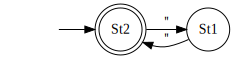

In [10]:
dotObj_nfa(n0)

In [11]:
n0

{'Delta': {('St1', ''): {'St2'}, ('St2', ''): {'St1'}},
 'F': {'St2'},
 'Q': {'St1', 'St2'},
 'Q0': {'St2'},
 'Sigma': set()}

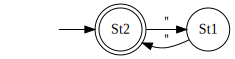

In [12]:
dotObj_nfa( re2nfa( "''*") )

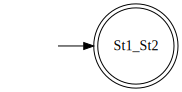

In [13]:
dotObj_dfa( nfa2dfa(re2nfa( "''*") ) )

In [14]:
NFA6 =  {'Q': {'I', 'F'},
         'Sigma': {'0', '1'},
         'Delta': {  
                   ('I', '0') : {'F'},
                   ('F', '1') : {'I'}
                   },
         'Q0': {'I'}, 
         'F' : {'F'}   
}
is_consistent_nfa(NFA6)
is_consistent_nfa(NFA6)
GN6 = mk_gnfa(NFA6)
(GF6, do6, restr6) = del_gnfa_states(GN6)
#do6[2]

**** Eliminating state I ****
**** Eliminating state F ****


In [15]:
restr6

'(0 ((1 0))*)'

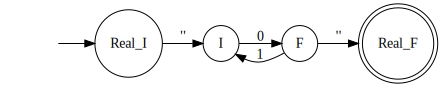

In [16]:
dotObj_gnfa(GN6)

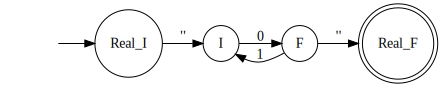

In [17]:
do6[0]

In [18]:
RE2Str(("*","a"))

'(a)*'

In [19]:
RE2Str(("+",("a", "b")))

'(a + b)'

In [20]:
RE2Str((".",("", "")))

'("" "")'

In [21]:
RE2Str((".",("a", "b")))

'(a b)'

In [22]:
RE2Str(("+",( ("+",("a", "b")) , (".",("c", ("*","d") )) ) ) )

'((a + b) + (c (d)*))'

In [23]:
D34bl = { 'Q': {'A', 'IF', 'B', 'A1', 'B1'},
  'Sigma': {'0', '1'},
  'Delta': { ('IF', '0'): 'A',
             ('IF', '1'): 'IF',
             ('A', '0'): 'B1',
             ('A', '1'): 'A1',
             ('A1', '0'): 'B',
             ('A1', '1'): 'A',
             ('B1', '0'): 'IF',
             ('B1', '1'): 'B',
             ('B','0') : 'IF',
             ('B', '1'): 'B1' },
  'q0': 'IF', 
  'F': {'IF'}   
}

N1  = dfa2nfa(D34bl)
is_consistent_nfa(N1)

True

In [24]:
GN1 = mk_gnfa(N1)
is_consistent_nfa(N1)

True

In [25]:
DFA_fig34 = { 'Q': {'A', 'IF', 'B'},
              'Sigma': {'0', '1'},
              'Delta': { ('IF', '0'): 'A',
                         ('IF', '1'): 'IF',
                         ('A', '0'): 'B',
                         ('A', '1'): 'A',
                         ('B', '0'): 'IF',
                         ('B', '1'): 'B' },
              'q0': 'IF', 
              'F': {'IF'}   
             }

NFA_fig34 = dfa2nfa(DFA_fig34)

GN2 = mk_gnfa(dfa2nfa(DFA_fig34))



N3  = dfa2nfa(D34bl)
is_consistent_nfa(N3)
GN3 = mk_gnfa(N3)

In [26]:
DFmulti   = { 'Q': {'I', 'F', 'A'},
              'Sigma': {'0', '1'},
              'Delta': { ('I', '0') :  'A',
                         ('I', '1') :  'A',
                         ('A', '0') :  'A',
                         ('A', '1') :  'F',
                         ('F', '0') :  'I',
                         ('F', '1') :  'I' },
              'q0': 'I', 
              'F': {'F'}   
             }
GN4 = mk_gnfa(dfa2nfa(DFmulti))

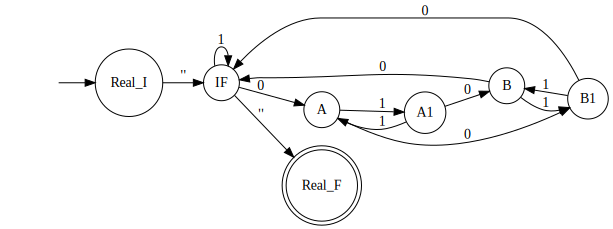

In [27]:
dotObj_nfa(GN1)

In [28]:
(GNf, doL, restr1) = del_gnfa_states(GN1)

**** Eliminating state A1 ****
**** Eliminating state B1 ****
**** Eliminating state A ****
**** Eliminating state IF ****
**** Eliminating state B ****


In [29]:
form_alt_RE(Edges_Exist_Via(GNf, "Real_I", "Real_F"))

('+',
 (('*',
   ('+',
    ('1',
     ('+',
      (('.', ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
       '1'))))),
  ('+',
   (('.',
     (('.',
       (('*',
         ('+',
          ('1',
           ('+',
            (('.',
              ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
             '1'))))),
        ('.',
         ('0',
          ('.',
           (('*', ('.', ('1', '1'))),
            ('+',
             (('.', ('1', '0')),
              ('+', (('.', ('0', '1')), ('.', ('1', '0')))))))))))),
      ('.',
       (('*',
         ('+',
          (('.', ('1', '1')),
           ('+',
            (('.',
              (('+', ('0', ('+', (('.', ('1', '0')), '0')))),
               ('.',
                (('*',
                  ('+',
                   ('1',
                    ('+',
                     (('.',
                       ('0',
                        ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
                      '1')

In [30]:
Edges_Exist_Via(GNf, "Real_I", "Real_F")

[('+',
  (('*',
    ('+',
     ('1',
      ('+',
       (('.', ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
        '1'))))),
   ('+',
    (('.',
      (('.',
        (('*',
          ('+',
           ('1',
            ('+',
             (('.',
               ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
              '1'))))),
         ('.',
          ('0',
           ('.',
            (('*', ('.', ('1', '1'))),
             ('+',
              (('.', ('1', '0')),
               ('+', (('.', ('0', '1')), ('.', ('1', '0')))))))))))),
       ('.',
        (('*',
          ('+',
           (('.', ('1', '1')),
            ('+',
             (('.',
               (('+', ('0', ('+', (('.', ('1', '0')), '0')))),
                ('.',
                 (('*',
                   ('+',
                    ('1',
                     ('+',
                      (('.',
                        ('0',
                         ('.',
                          (('*', ('.'

In [31]:
doL

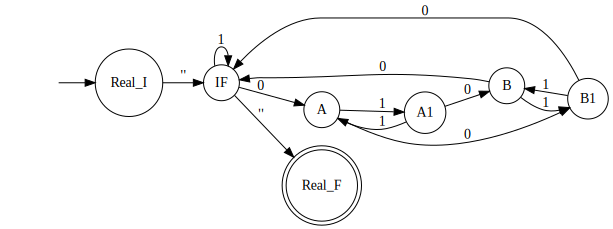

In [32]:
dotObj_gnfa(GN1)

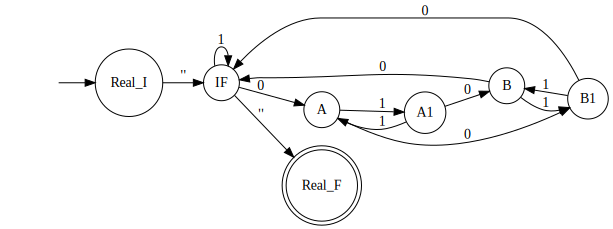

In [33]:
doL[0]

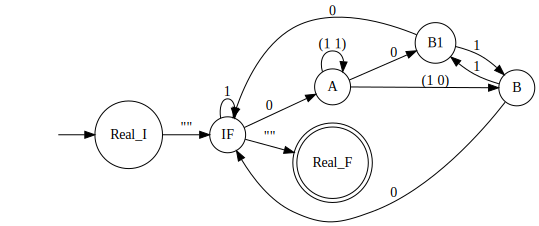

In [34]:
doL[1]

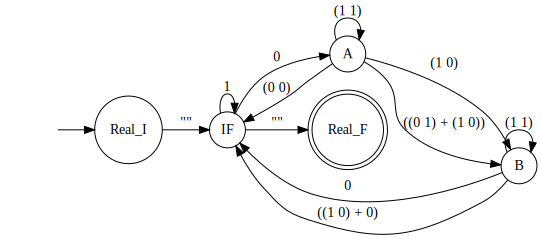

In [35]:
doL[2]

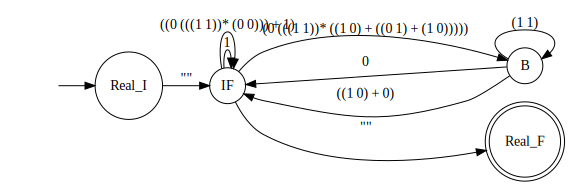

In [36]:
doL[3]

In [37]:
restr1

'(((1 + ((0 (((1 1))* (0 0))) + 1)))* + (((((1 + ((0 (((1 1))* (0 0))) + 1)))* (0 (((1 1))* ((1 0) + ((0 1) + (1 0)))))) ((((1 1) + (((0 + ((1 0) + 0)) (((1 + ((0 (((1 1))* (0 0))) + 1)))* (0 (((1 1))* ((1 0) + ((0 1) + (1 0))))))) + (1 1))))* ((0 + ((1 0) + 0)) ((1 + ((0 (((1 1))* (0 0))) + 1)))*))) + ((1 + ((0 (((1 1))* (0 0))) + 1)))*))'

In [38]:
Edges_Exist_Via(GN1, "I", "A")

'NOEDGE'

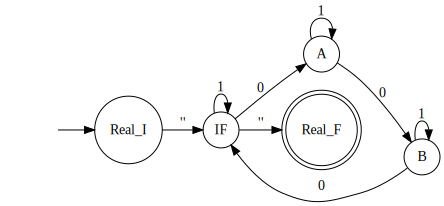

In [39]:
dotObj_gnfa(GN2)

In [40]:
(GNf2, doL2, restr2) = del_gnfa_states(GN2)

**** Eliminating state A ****
**** Eliminating state IF ****
**** Eliminating state B ****


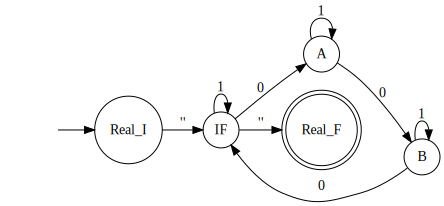

In [41]:
doL2[0]

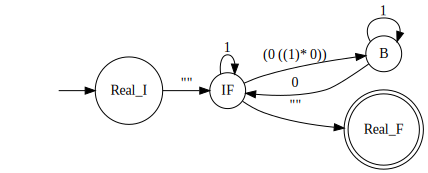

In [42]:
doL2[1]

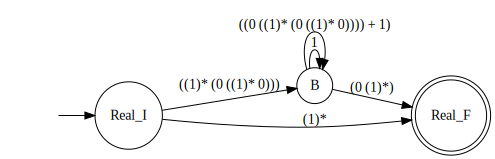

In [43]:
doL2[2]

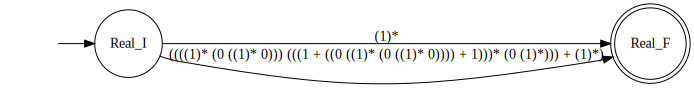

In [44]:
doL2[3]

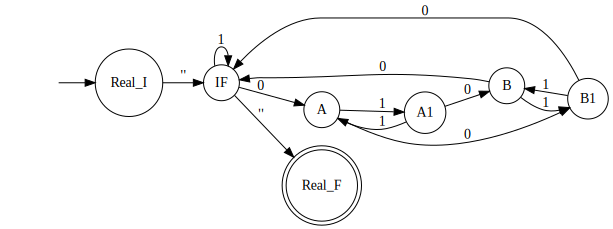

In [45]:
dotObj_gnfa(GN3)

In [46]:
(GNf3, doL3, restr3) = del_gnfa_states(GN3)

**** Eliminating state A1 ****
**** Eliminating state B1 ****
**** Eliminating state A ****
**** Eliminating state IF ****
**** Eliminating state B ****


In [47]:
GNf3

{'Delta': {('Real_I',
   ('+',
    (('*',
      ('+',
       ('1',
        ('+',
         (('.', ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
          '1'))))),
     ('+',
      (('.',
        (('.',
          (('*',
            ('+',
             ('1',
              ('+',
               (('.',
                 ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
                '1'))))),
           ('.',
            ('0',
             ('.',
              (('*', ('.', ('1', '1'))),
               ('+',
                (('.', ('1', '0')),
                 ('+', (('.', ('0', '1')), ('.', ('1', '0')))))))))))),
         ('.',
          (('*',
            ('+',
             (('.', ('1', '1')),
              ('+',
               (('.',
                 (('+', ('0', ('+', (('.', ('1', '0')), '0')))),
                  ('.',
                   (('*',
                     ('+',
                      ('1',
                       ('+',
                        (('.',
  

In [48]:
restr3

'(((1 + ((0 (((1 1))* (0 0))) + 1)))* + (((((1 + ((0 (((1 1))* (0 0))) + 1)))* (0 (((1 1))* ((1 0) + ((0 1) + (1 0)))))) ((((1 1) + (((0 + ((1 0) + 0)) (((1 + ((0 (((1 1))* (0 0))) + 1)))* (0 (((1 1))* ((1 0) + ((0 1) + (1 0))))))) + (1 1))))* ((0 + ((1 0) + 0)) ((1 + ((0 (((1 1))* (0 0))) + 1)))*))) + ((1 + ((0 (((1 1))* (0 0))) + 1)))*))'

In [49]:
Es = Edges_Exist_Via(GNf3, "Real_I", "Real_F")

In [50]:
Es[0]

('+',
 (('*',
   ('+',
    ('1',
     ('+',
      (('.', ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
       '1'))))),
  ('+',
   (('.',
     (('.',
       (('*',
         ('+',
          ('1',
           ('+',
            (('.',
              ('0', ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
             '1'))))),
        ('.',
         ('0',
          ('.',
           (('*', ('.', ('1', '1'))),
            ('+',
             (('.', ('1', '0')),
              ('+', (('.', ('0', '1')), ('.', ('1', '0')))))))))))),
      ('.',
       (('*',
         ('+',
          (('.', ('1', '1')),
           ('+',
            (('.',
              (('+', ('0', ('+', (('.', ('1', '0')), '0')))),
               ('.',
                (('*',
                  ('+',
                   ('1',
                    ('+',
                     (('.',
                       ('0',
                        ('.', (('*', ('.', ('1', '1'))), ('.', ('0', '0')))))),
                      '1')

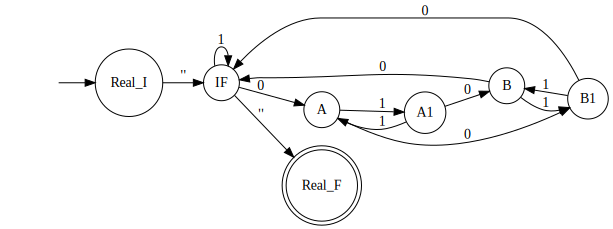

In [51]:
doL3[0]

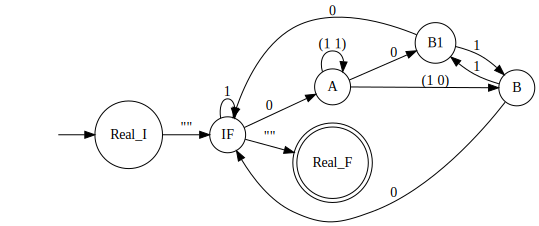

In [52]:
doL3[1]

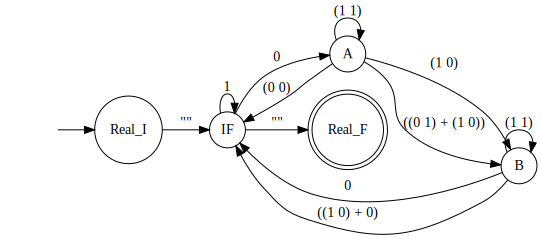

In [53]:
doL3[2]

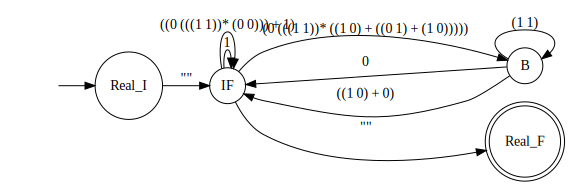

In [54]:
doL3[3]

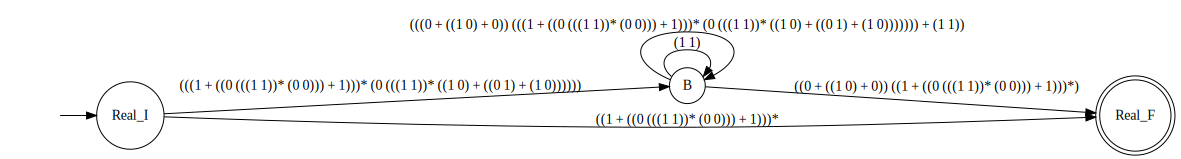

In [55]:
doL3[4]

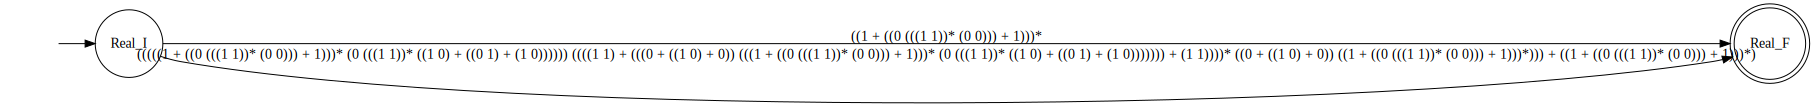

In [56]:
doL3[5]

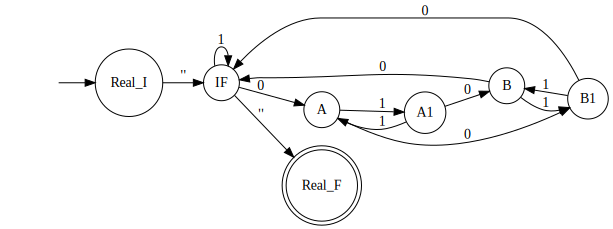

In [57]:
dotObj_nfa(GN3)

In [58]:
(GNf3, doL3, restr3) = del_gnfa_states(GN3)

**** Eliminating state A1 ****
**** Eliminating state B1 ****
**** Eliminating state A ****
**** Eliminating state IF ****
**** Eliminating state B ****


In [59]:
restr3

'(((1 + ((0 (((1 1))* (0 0))) + 1)))* + (((((1 + ((0 (((1 1))* (0 0))) + 1)))* (0 (((1 1))* ((1 0) + ((0 1) + (1 0)))))) ((((1 1) + (((0 + ((1 0) + 0)) (((1 + ((0 (((1 1))* (0 0))) + 1)))* (0 (((1 1))* ((1 0) + ((0 1) + (1 0))))))) + (1 1))))* ((0 + ((1 0) + 0)) ((1 + ((0 (((1 1))* (0 0))) + 1)))*))) + ((1 + ((0 (((1 1))* (0 0))) + 1)))*))'

In [60]:
del_one_gnfa_state(GN3, "B", "B1", "B")

('.', ('1', '1'))

In [61]:
del_one_gnfa_state(GN3, "B", "IF", "A")

('.', ('0', ('.', (('*', '1'), '0'))))

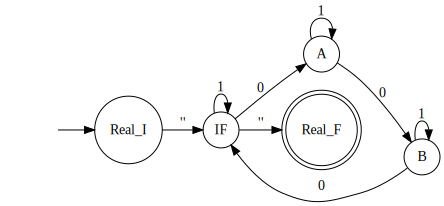

In [62]:
GN4 = mk_gnfa(NFA_fig34)
dotObj_nfa(GN4)

In [63]:
NFA_fig34

{'Delta': {('A', '0'): {'B'},
  ('A', '1'): {'A'},
  ('B', '0'): {'IF'},
  ('B', '1'): {'B'},
  ('IF', '0'): {'A'},
  ('IF', '1'): {'IF'}},
 'F': {'IF'},
 'Q': {'A', 'B', 'IF'},
 'Q0': {'IF'},
 'Sigma': {'0', '1'}}

In [64]:
(GNf4, doL4, restr4) = del_gnfa_states(GN4)

**** Eliminating state A ****
**** Eliminating state IF ****
**** Eliminating state B ****


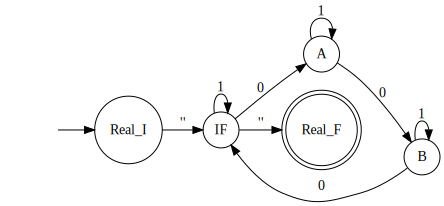

In [65]:
doL4[0]

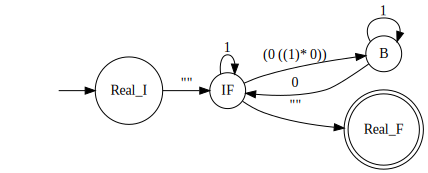

In [66]:
doL4[1]

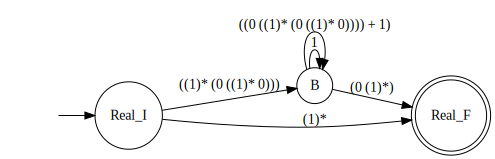

In [67]:
doL4[2]

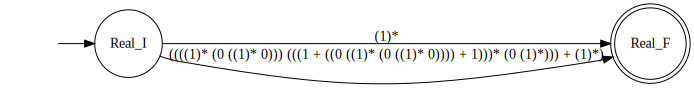

In [68]:
doL4[3]

In [69]:
restr4

'((1)* + ((((1)* (0 ((1)* 0))) (((1 + ((0 ((1)* (0 ((1)* 0)))) + 1)))* (0 (1)*))) + (1)*))'

In [70]:
del_one_gnfa_state(GN4, "B", "IF", "A")

('.', ('0', ('.', (('*', '1'), '0'))))

In [71]:
del_one_gnfa_state(GN4, "B", "IF", "Real_I")

'NOPATH'

In [72]:
NFA_fig61ab = \
{ 'Q': {'I', 'S0', 'S1', 'S2', 'F'},
  'Sigma': {'0', '1'},
  'Delta': { # 
             ('I', '0')  : {'I'},
             ('I', '1')  : {'I', 'S0'},
             ('I', '')   : {'S0'},
             #
             ('S0', '1') : {'S1'},
             #
             ('S1', '0') : {'S2'},
             ('S1', '1') : {'S2'},
             #
             ('S2', '0') : {'F'},
             ('S2', '1') : {'F'},
           },
  'Q0': {'I'}, 
  'F' : {'F'}   
}

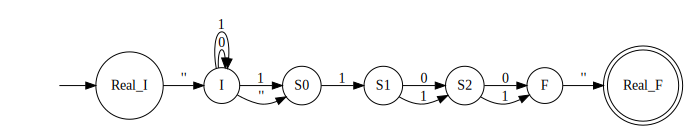

In [73]:
GN5 = mk_gnfa(NFA_fig61ab)
dotObj_gnfa(GN5)

In [74]:
(GNf5, doL5, restr5) = del_gnfa_states(GN5)

**** Eliminating state S2 ****
**** Eliminating state S0 ****
**** Eliminating state S1 ****
**** Eliminating state F ****
**** Eliminating state I ****


In [75]:
GNf5

{'Delta': {('Real_I',
   ('.',
    (('*', ('+', ('0', '1'))),
     ('.',
      (('.', (('+', ('1', '')), '1')),
       ('.', (('+', ('0', '1')), ('+', ('0', '1'))))))))): {'Real_F'}},
 'F': {'Real_F'},
 'Q': {'Real_F', 'Real_I'},
 'Q0': {'Real_I'},
 'Sigma': {('.',
   (('*', ('+', ('0', '1'))),
    ('.',
     (('.', (('+', ('1', '')), '1')),
      ('.', (('+', ('0', '1')), ('+', ('0', '1'))))))))}}

In [76]:
restr5

'(((0 + 1))* (((1 + "") 1) ((0 + 1) (0 + 1))))'

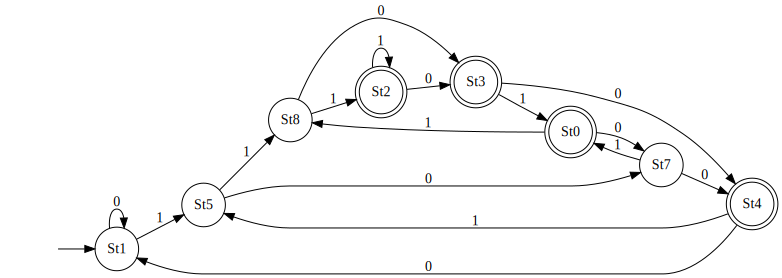

In [77]:
dotObj_dfa(min_dfa(nfa2dfa(re2nfa(restr5))))

In [78]:
form_alt_RE( Edges_Exist_Via(GNf5, "Real_I", "Real_F") )

('.',
 (('*', ('+', ('0', '1'))),
  ('.',
   (('.', (('+', ('1', '')), '1')),
    ('.', (('+', ('0', '1')), ('+', ('0', '1'))))))))

In [79]:
restr5

'(((0 + 1))* (((1 + "") 1) ((0 + 1) (0 + 1))))'

In [80]:
RE2Str(restr5)

'(((0 + 1))* (((1 + "") 1) ((0 + 1) (0 + 1))))'

In [81]:
Edges_Exist_Via(GNf5, "Real_I", "Real_F")

[('.',
  (('*', ('+', ('0', '1'))),
   ('.',
    (('.', (('+', ('1', '')), '1')),
     ('.', (('+', ('0', '1')), ('+', ('0', '1'))))))))]

In [82]:
GNf5

{'Delta': {('Real_I',
   ('.',
    (('*', ('+', ('0', '1'))),
     ('.',
      (('.', (('+', ('1', '')), '1')),
       ('.', (('+', ('0', '1')), ('+', ('0', '1'))))))))): {'Real_F'}},
 'F': {'Real_F'},
 'Q': {'Real_F', 'Real_I'},
 'Q0': {'Real_I'},
 'Sigma': {('.',
   (('*', ('+', ('0', '1'))),
    ('.',
     (('.', (('+', ('1', '')), '1')),
      ('.', (('+', ('0', '1')), ('+', ('0', '1'))))))))}}

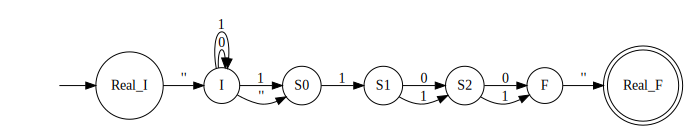

In [83]:
doL5[0]

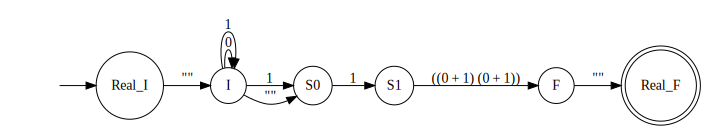

In [84]:
doL5[1]

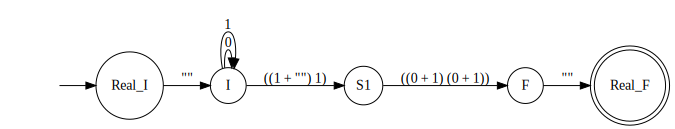

In [85]:
doL5[2]

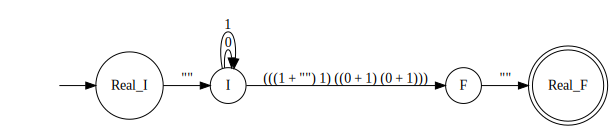

In [86]:
doL5[3]

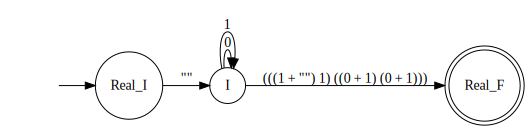

In [87]:
doL5[4]

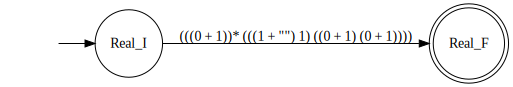

In [88]:
doL5[5]

In [89]:
restr5

'(((0 + 1))* (((1 + "") 1) ((0 + 1) (0 + 1))))'

In [90]:
re2nfa(restr5)

{'Delta': {('St1', '0'): {'St2'},
  ('St10', ''): {'St11', 'St13'},
  ('St11', '0'): {'St12'},
  ('St12', ''): {'St15', 'St17'},
  ('St13', '1'): {'St14'},
  ('St14', ''): {'St15', 'St17'},
  ('St15', '0'): {'St16'},
  ('St17', '1'): {'St18'},
  ('St2', ''): {'St5'},
  ('St3', '1'): {'St4'},
  ('St4', ''): {'St5'},
  ('St5', ''): {'St1', 'St3', 'St6', 'St8'},
  ('St6', '1'): {'St7'},
  ('St7', ''): {'St9'},
  ('St8', ''): {'St9'},
  ('St9', '1'): {'St10'}},
 'F': {'St16', 'St18'},
 'Q': {'St1',
  'St10',
  'St11',
  'St12',
  'St13',
  'St14',
  'St15',
  'St16',
  'St17',
  'St18',
  'St2',
  'St3',
  'St4',
  'St5',
  'St6',
  'St7',
  'St8',
  'St9'},
 'Q0': {'St5'},
 'Sigma': {'0', '1'}}

In [91]:
NFA6 =  {'Q': {'I', 'F'},
         'Sigma': {'0', '1'},
         'Delta': {  
                   ('I', '0') : {'F'},
                   ('F', '1') : {'I'}
                   },
         'Q0': {'I'}, 
         'F' : {'F'}   
}
GN6 = mk_gnfa(NFA6)
del_gnfa_states(GN6)

**** Eliminating state I ****
**** Eliminating state F ****


({'Delta': {('Real_I', ('.', ('0', ('*', ('.', ('1', '0')))))): {'Real_F'}},
  'F': {'Real_F'},
  'Q': {'Real_F', 'Real_I'},
  'Q0': {'Real_I'},
  'Sigma': {('.', ('0', ('*', ('.', ('1', '0')))))}},
 '(0 ((1 0))*)')

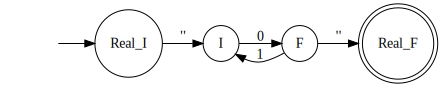

In [92]:
GN6 = mk_gnfa(NFA6)
dotObj_gnfa(GN6)

In [93]:
del_gnfa_states(GN6)

**** Eliminating state I ****
**** Eliminating state F ****


({'Delta': {('Real_I', ('.', ('0', ('*', ('.', ('1', '0')))))): {'Real_F'}},
  'F': {'Real_F'},
  'Q': {'Real_F', 'Real_I'},
  'Q0': {'Real_I'},
  'Sigma': {('.', ('0', ('*', ('.', ('1', '0')))))}},
 '(0 ((1 0))*)')

In [94]:
(Gf6, do6, restr6) = del_gnfa_states(GN6)

**** Eliminating state I ****
**** Eliminating state F ****


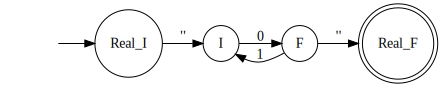

In [95]:
do6[0]

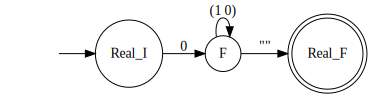

In [96]:
do6[1]

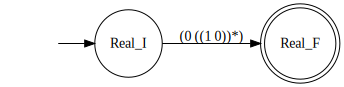

In [97]:
do6[2]

In [98]:
del_one_gnfa_state(GN6, "I", "F", "I")

('.', ('0', '1'))

In [99]:
del_one_gnfa_state(GN6, "I", "F", "Real_F")

'0'

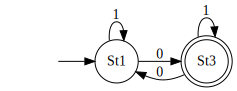

In [100]:
dotObj_dfa(min_dfa(nfa2dfa(re2nfa( "1*01*(01*01*)*" ))))

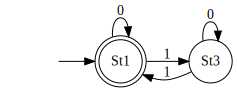

In [101]:
dotObj_dfa(min_dfa(nfa2dfa(re2nfa( "0*(10*10*)*" ))))

In [102]:
even1sdfa = min_dfa(nfa2dfa(re2nfa( "0*(10*10*)*" )))

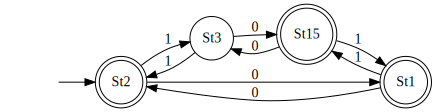

In [103]:
dotObj_dfa(min_dfa(nfa2dfa(re2nfa( "0*(10*10*)*  +  1*01*(01*01*)*" ))))

In [104]:
def dfa2re(D):
    return del_gnfa_states(mk_gnfa_from_D(D))

In [105]:
(GNev1, doev1, restrev1) = dfa2re(even1sdfa)

**** Eliminating state St3 ****
**** Eliminating state St1 ****


In [106]:
restrev1

'((0 + ((1 ((0)* 1)) + 0)))*'

In [107]:
minev1 = min_dfa(nfa2dfa(re2nfa( "0*(10*10*)*" )))
(Gev1, doev1, reev1) = del_gnfa_states(mk_gnfa_from_D(minev1))
minev2 = min_dfa(nfa2dfa(re2nfa(reev1)))

**** Eliminating state St3 ****
**** Eliminating state St1 ****


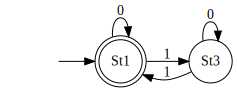

In [108]:
dotObj_dfa(minev1)

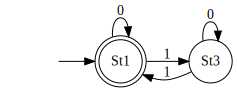

In [109]:
dotObj_dfa(minev2)

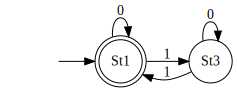

In [110]:
dotObj_dfa(min_dfa(nfa2dfa(re2nfa( "((0+((1((0)*1))+0)))*" ))))

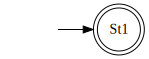

In [111]:
dotObj_nfa(re2nfa("''"))

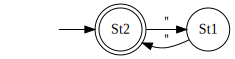

In [112]:
dotObj_nfa(re2nfa("''*"))

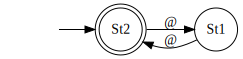

In [113]:
dotObj_nfa(re2nfa("''*"), visible_eps = True)

In [114]:
re2nfa("''*")

{'Delta': {('St1', ''): {'St2'}, ('St2', ''): {'St1'}},
 'F': {'St2'},
 'Q': {'St1', 'St2'},
 'Q0': {'St2'},
 'Sigma': set()}

In [115]:
min_dfa_brz

<function jove.Module4_NFA.min_dfa_brz>

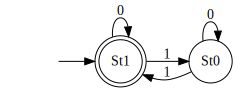

In [116]:
dotObj_dfa(min_dfa_brz(nfa2dfa(re2nfa( "((0+((1((0)*1))+0)))* + '' " ))))

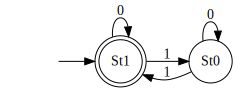

In [117]:
dotObj_dfa(min_dfa_brz(nfa2dfa(re2nfa( "((0+((1((0)*1))+0)))* + '' " ))))

In [118]:
"0*(10*10*)*"

'0*(10*10*)*'

In [119]:
ev1od0 = "0*(10*10*)* + 1*01*(01*01*)*"

In [120]:
minb_ev1od0 = min_dfa_brz(nfa2dfa(re2nfa(ev1od0)))

In [121]:
mino_ev1od0 = min_dfa(nfa2dfa(re2nfa(ev1od0)))

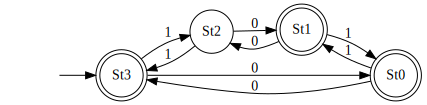

In [122]:
dotObj_dfa(minb_ev1od0)

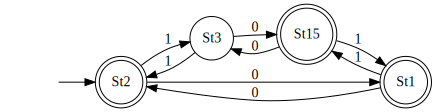

In [123]:
dotObj_dfa(mino_ev1od0)

In [124]:
del_gnfa_states

<function __main__.del_gnfa_states>

In [125]:
mk_gnfa_from_D

<function __main__.mk_gnfa_from_D>

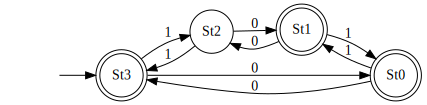

In [126]:
minb_ev1od0 = min_dfa_brz(nfa2dfa(re2nfa(ev1od0)))
dotObj_dfa(minb_ev1od0)

In [127]:
(Ge1o0, do_e1o0, re_e1o0) = del_gnfa_states(mk_gnfa_from_D(minb_ev1od0))

**** Eliminating state St1 ****
**** Eliminating state St2 ****
**** Eliminating state St3 ****
**** Eliminating state St0 ****


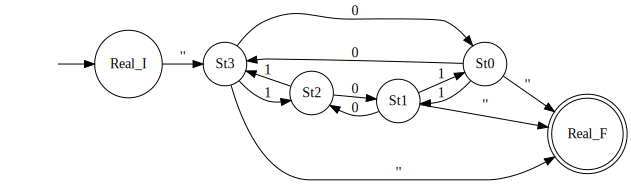

In [128]:
do_e1o0[0]

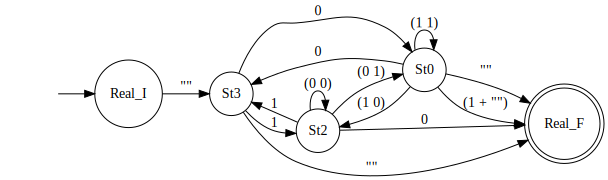

In [129]:
do_e1o0[1]

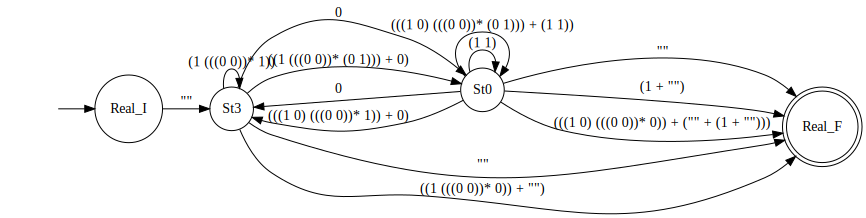

In [130]:
do_e1o0[2]

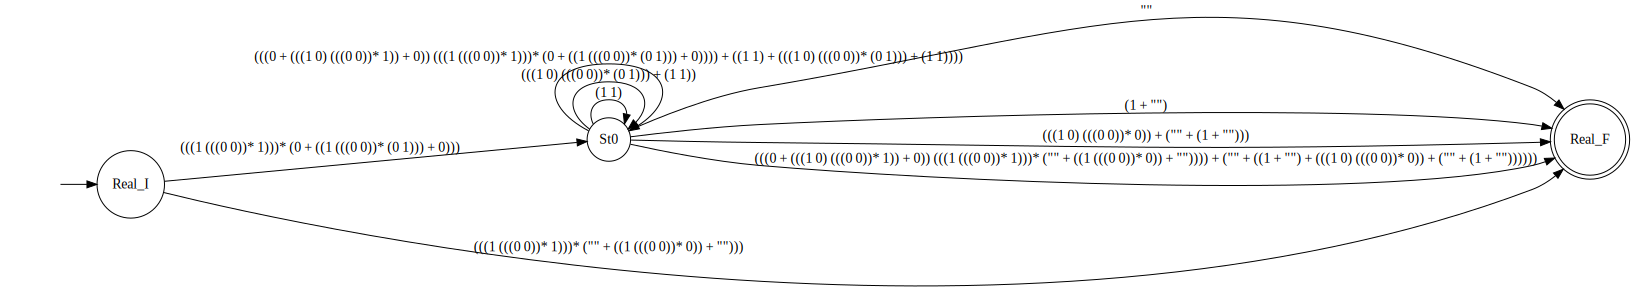

In [131]:
do_e1o0[3]

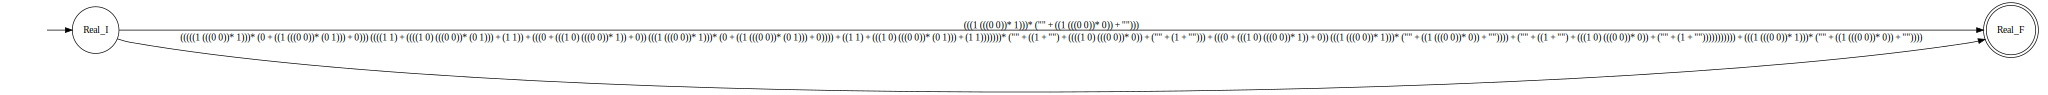

In [132]:
do_e1o0[4]

In [133]:
re_e1o0

'((((1 (((0 0))* 1)))* ("" + ((1 (((0 0))* 0)) + ""))) + (((((1 (((0 0))* 1)))* (0 + ((1 (((0 0))* (0 1))) + 0))) ((((1 1) + ((((1 0) (((0 0))* (0 1))) + (1 1)) + (((0 + (((1 0) (((0 0))* 1)) + 0)) (((1 (((0 0))* 1)))* (0 + ((1 (((0 0))* (0 1))) + 0)))) + ((1 1) + (((1 0) (((0 0))* (0 1))) + (1 1)))))))* ("" + ((1 + "") + ((((1 0) (((0 0))* 0)) + ("" + (1 + ""))) + (((0 + (((1 0) (((0 0))* 1)) + 0)) (((1 (((0 0))* 1)))* ("" + ((1 (((0 0))* 0)) + "")))) + ("" + ((1 + "") + (((1 0) (((0 0))* 0)) + ("" + (1 + ""))))))))))) + (((1 (((0 0))* 1)))* ("" + ((1 (((0 0))* 0)) + "")))))'

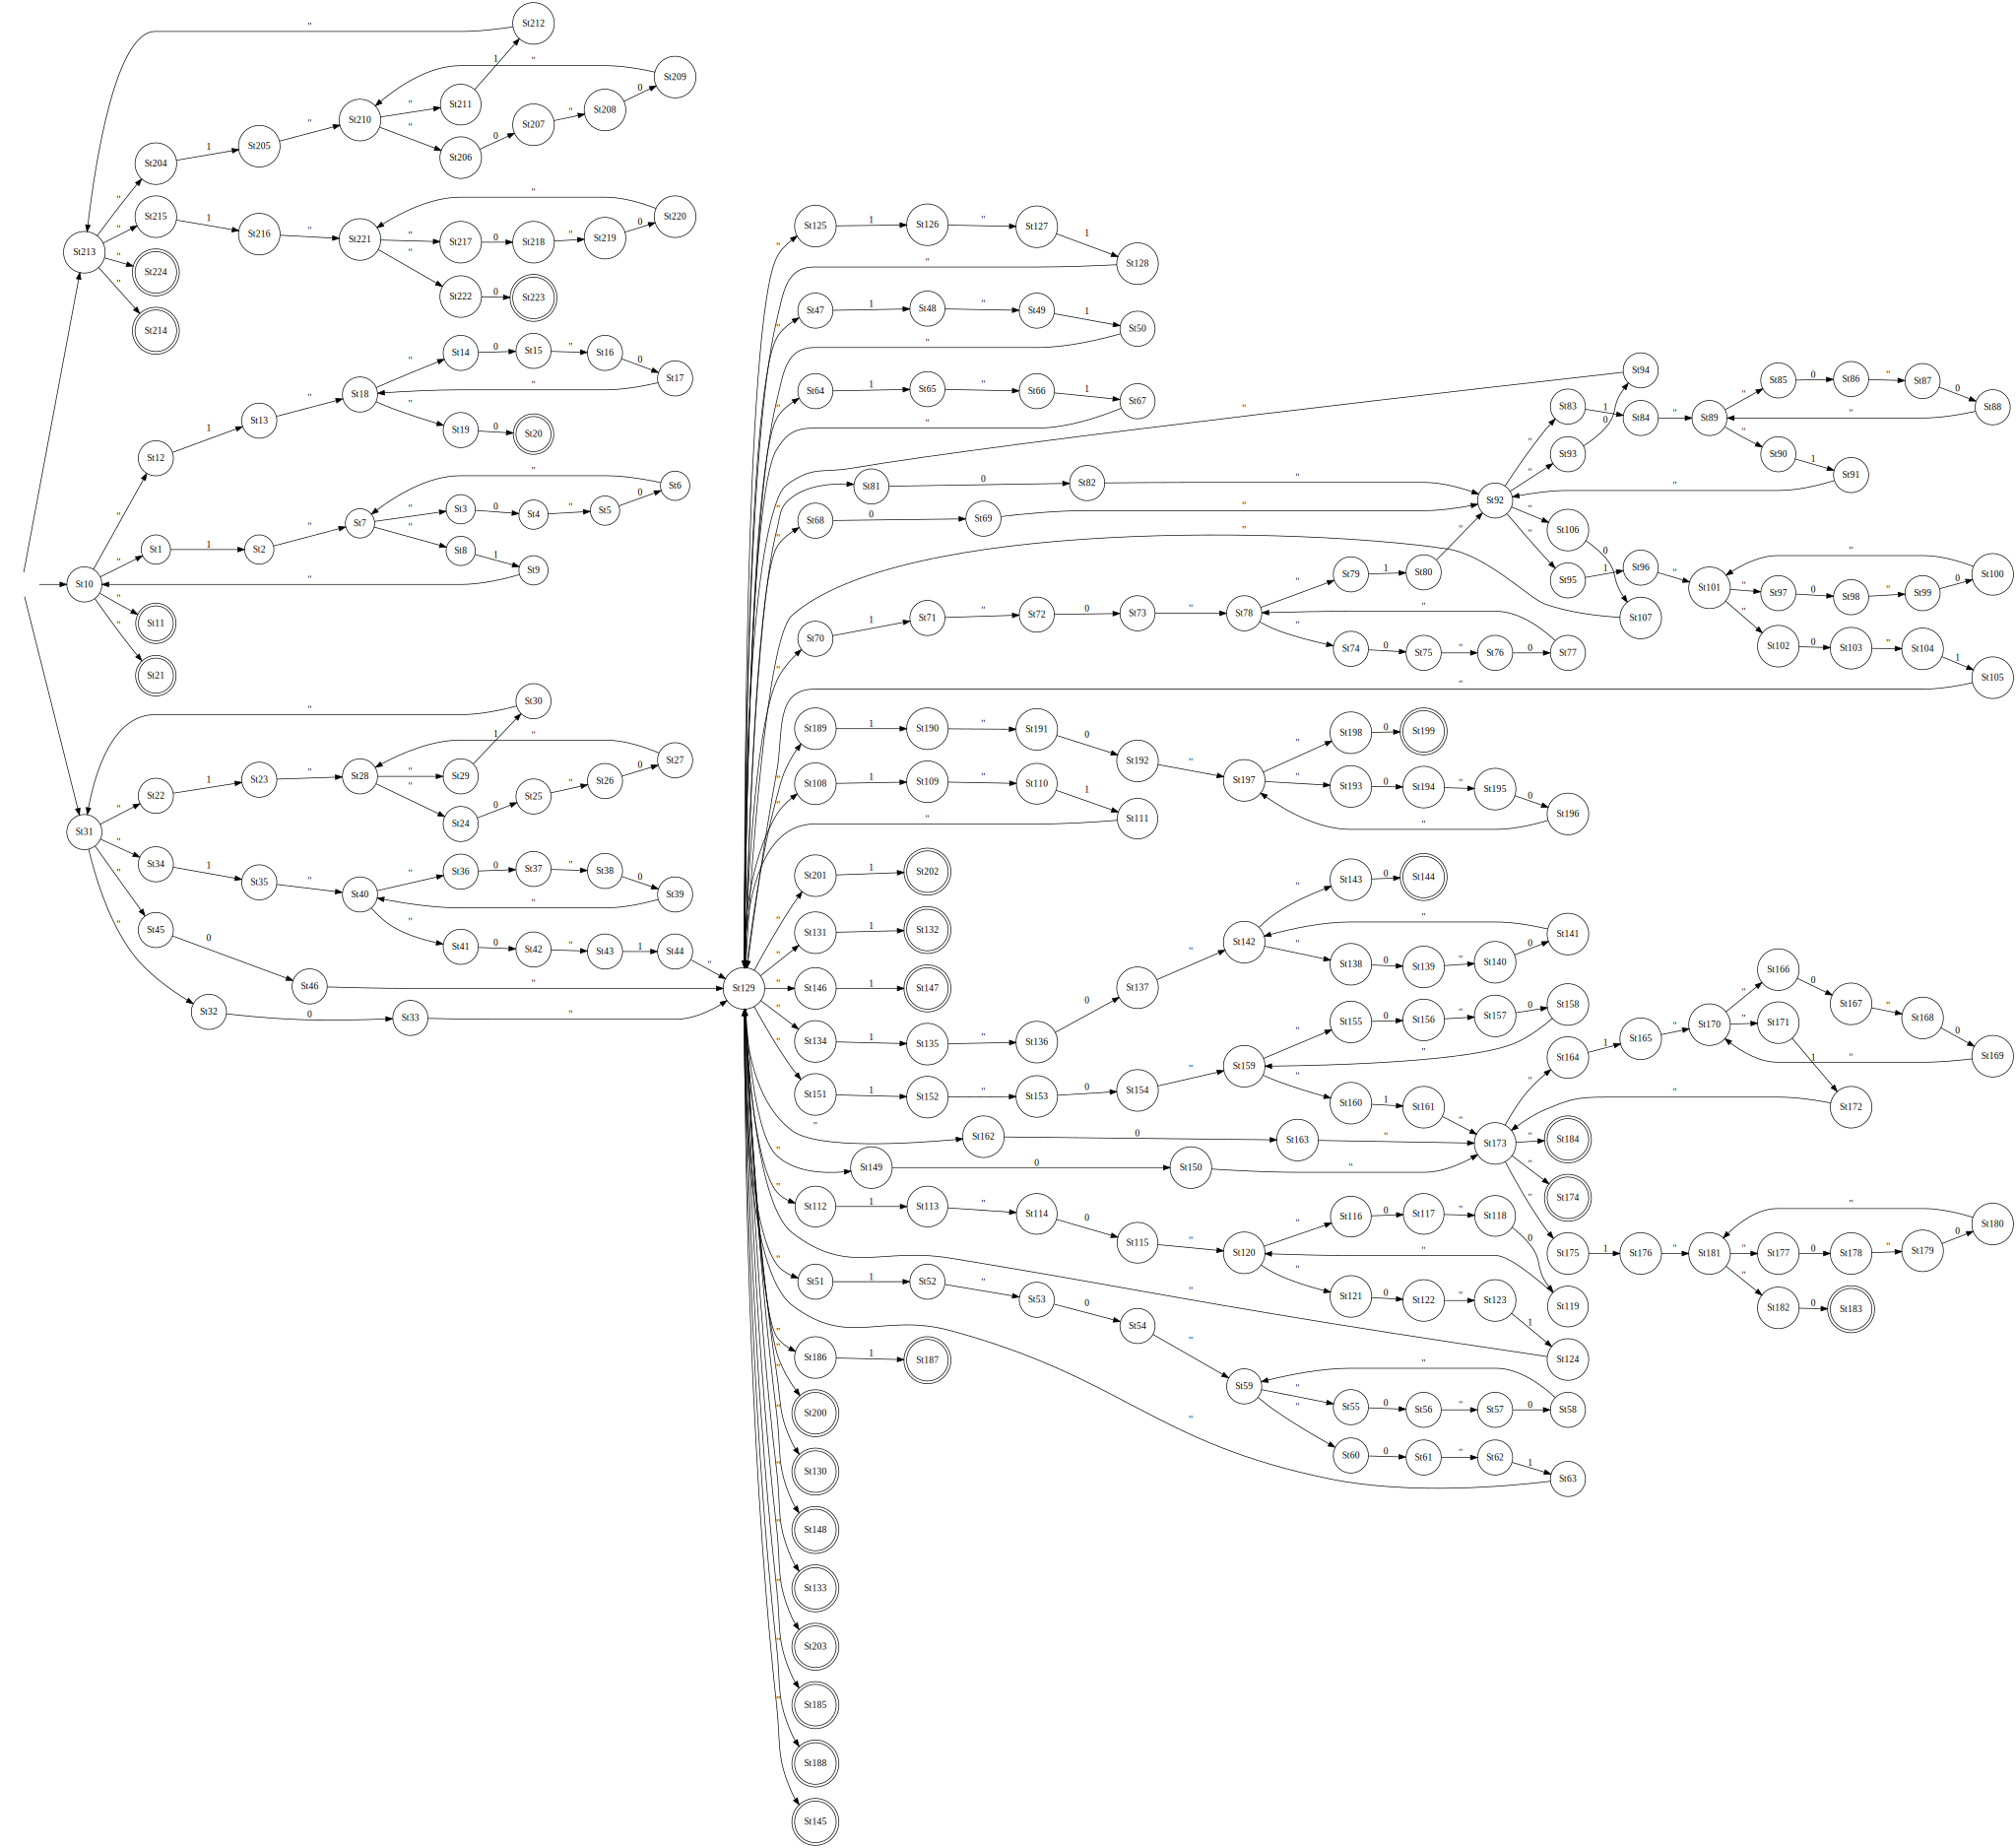

In [134]:
dotObj_nfa(re2nfa(re_e1o0))

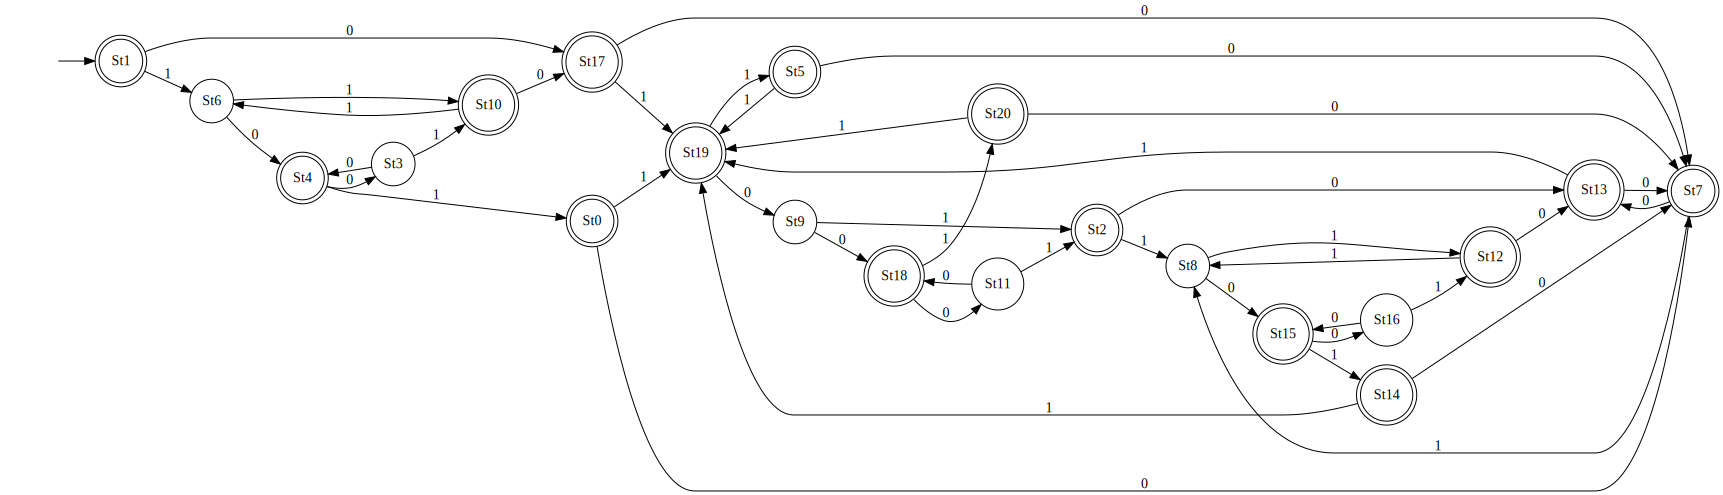

In [135]:
dotObj_dfa(nfa2dfa(re2nfa(re_e1o0)))

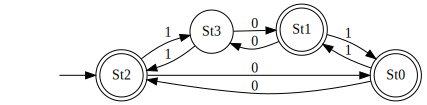

In [136]:
dotObj_dfa(min_dfa_brz(nfa2dfa(re2nfa(re_e1o0))))